In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as st
import statsmodels.api as sm
import datetime

read_path = r'C:\Users\XeniaRieger\OneDrive - bwedu\Dokumente\Studium Master\1. Semester\Data Literacy\Data-Literacy\Data\joined_survey_article_standardized_median.csv'
df = pd.read_csv(read_path, delimiter=';', header=0)
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
df["SPD"] = pd.to_numeric(df["SPD"], errors='coerce')
df["Union"] = pd.to_numeric(df["Union"], errors='coerce')
df["Grüne"] = pd.to_numeric(df["Grüne"], errors='coerce')
df["FDP"] = pd.to_numeric(df["FDP"], errors='coerce')
df["AfD"] = pd.to_numeric(df["AfD"], errors='coerce')
df["Linke"] = pd.to_numeric(df["Linke"], errors='coerce')

In [48]:
# filter data: get highest article values, long time before, short time after
dates_max = df.sort_values('standardized_war_articles').nlargest(10, 'standardized_war_articles')
df_res = pd.DataFrame(columns=["R2 Reg", "MSE Reg", "MSE Pred", "Mean diff"])
for date in dates_max['date']:
    df_res.loc[date, "R2 Reg"] = 0
    time_after = 3*7 # three weeks
    date_after = date + datetime.timedelta(days=time_after)
    total_df = df[df["date"] <= date_after]
    regression_df = total_df[total_df["date"] < date]
    pred_df = total_df[total_df["date"] >= date]
    for party in ["Union", "SPD", "Grüne", "FDP", "AfD", "Linke"]:
        regression_df = regression_df[(~regression_df[party].isna())]
        pred_df = pred_df[(~pred_df[party].isna())]
        if regression_df.empty or pred_df.empty:
            continue
        X = regression_df.index.values.reshape(-1,1)
        Y = regression_df[party]
        # fit model
        polynomial_features = PolynomialFeatures(degree=5)
        X_poly = polynomial_features.fit_transform(X)
        model = sm.OLS(Y, X_poly).fit()
        # get values for regression
        y_reg = model.predict(X_poly)
        mse_reg = mean_squared_error(Y, y_reg)
        df_res.loc[party, "MSE Reg"] = round(mse_reg, 2)
        r2_reg = r2_score(Y, y_reg)
        df_res.loc[party, "R2 Reg"] = round(r2_reg, 2)
        # get values for prediction
        X_pred = pred_df.index.values.reshape(-1,1)
        Y_pred = pred_df[party]
        X_pred_poly = polynomial_features.fit_transform(X_pred)
        y_pred = model.predict(X_pred_poly)
        mse_pred = mean_squared_error(Y_pred, y_pred)
        df_res.loc[party, "MSE Pred"] = round(mse_pred, 2)
        # calculate difference
        real_values = pred_df[party]
        diff = real_values - y_pred
        mean_diff = np.mean(diff)
        df_res.loc[party, "Mean diff"] = round(mean_diff, 2)

df_res

,R2 Reg,MSE Reg,MSE Pred,Mean diff
2003-03-28 00:00:00,0,NaN,NaN,NaN
Union,0.81,3.4,7.54,-2.71
SPD,0.7,4.16,3.12,1.66
Grüne,0.81,0.64,6.41,-2.49
FDP,0.67,0.92,9.99,3.15
2022-03-18 00:00:00,0,NaN,NaN,NaN
AfD,0.79,3.26,1.69,-1.3
Linke,0.68,0.59,1.48,-1.12
2003-04-04 00:00:00,0,NaN,NaN,NaN
2022-04-07 00:00:00,0,NaN,NaN,NaN


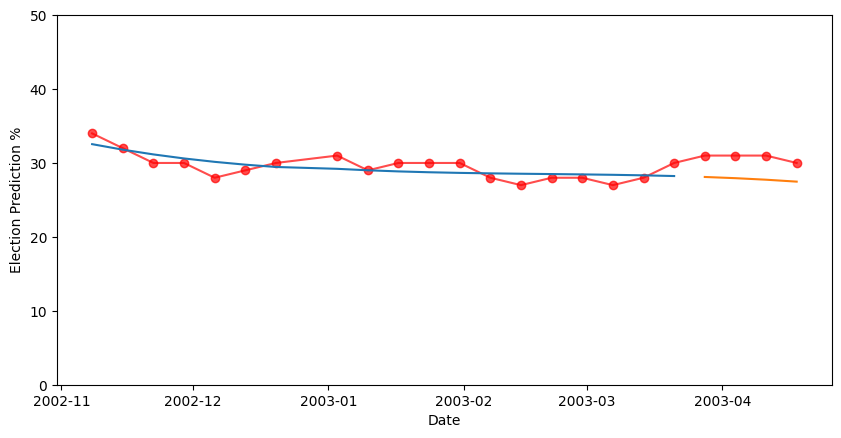

In [37]:
fig, ax1 = plt.subplots()
fig.set_figwidth(10) 
ax1.set_ylim([0, 50])
ax1.set_xlabel('Date') 
ax1.set_ylabel('Election Prediction %')
ax1.plot(total_df['date'], total_df['SPD'], marker='o', linestyle='-',label='SPD', color='red', alpha=0.7)
ax1.plot(regression_df['date'],ypred)
ax1.plot(pred_df['date'],ypred_future)